In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 553.5 kB/s eta 0:00:00


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer, create_head, create_body
import timm

In [3]:
train_images = "../input/petfinder-pawpularity-score/train"
test_images = "../input/petfinder-pawpularity-score/test"

In [4]:
train_images_path = Path(train_images)
test_images_path = Path(test_images)

In [5]:
train_df = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [6]:
def label_func(fname):
    img_id = fname.name.split(".")[0]
    return train_df[train_df["Id"] == img_id]["Pawpularity"].values[0]

In [7]:
dblock = DataBlock(
    blocks = [ImageBlock, RegressionBlock],
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=label_func,
    item_tfms = Resize(244),
    batch_tfms = aug_transforms()
)

In [8]:
dls = dblock.dataloaders(train_images_path)

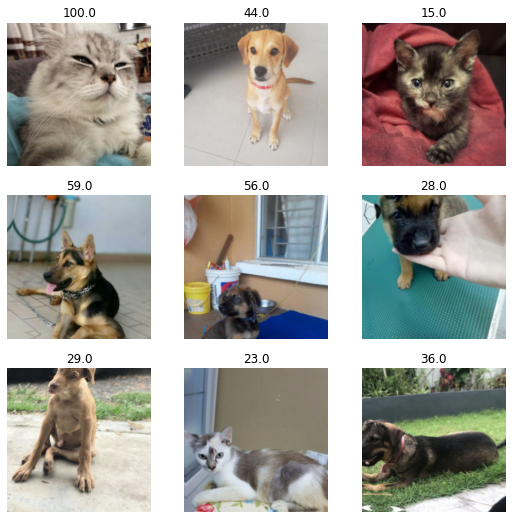

In [9]:
dls.train.show_batch()

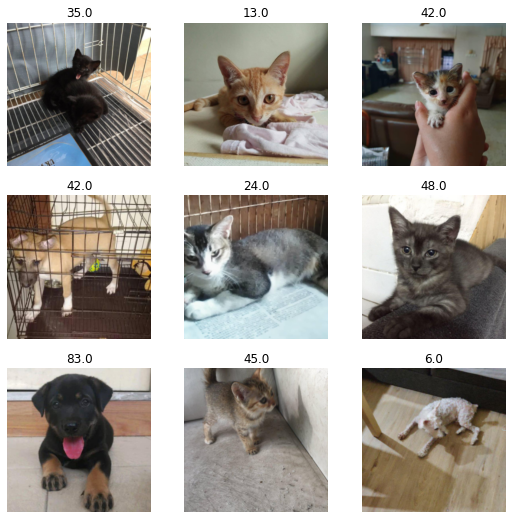

In [10]:
dls.valid.show_batch()

In [11]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
        "Creates a body from any model in the `timm` library."
        model = timm.create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
        _update_first_layer(model, n_in, pretrained)
        if cut is None:
            ll = list(enumerate(model.children()))
            cut = next(i for i,o in reversed(ll) if has_pool_type(o))
        if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
        elif callable(cut): return cut(model)
        else: raise NamedError("cut must be either integer or function")

In [12]:
body = create_timm_body('efficientnet_b0', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [13]:
nf = num_features_model(nn.Sequential(*body.children()))
nf

1280

In [14]:
head = create_head(nf, 1)

In [15]:
model = nn.Sequential(body, head)

In [16]:
apply_init(model[1], nn.init.kaiming_normal_)

In [17]:
learn = Learner(
                dls, 
                model, 
                loss_func=MSELossFlat(), 
                splitter=default_split
               )

In [18]:
learn.freeze()
learn.summary()

Sequential (Input shape: 64 x 3 x 244 x 244)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 122 x 122 
Conv2d                                    864        False     
Identity                                                       
SiLU                                                           
Conv2d                                    288        False     
Identity                                                       
SiLU                                                           
____________________________________________________________________________
                     64 x 8 x 1 x 1      
Conv2d                                    264        False     
SiLU                                                           
____________________________________________________________________________
                     64 x 32 x 1 x 1     
Conv2d                                    288        False     
Sigmoid                            

SuggestedLRs(valley=0.03981071710586548)

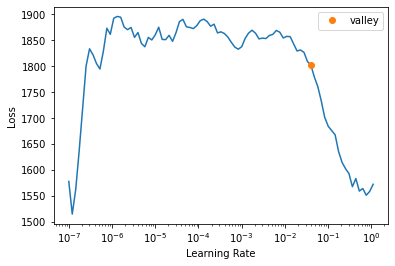

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(3, slice(3e-2))

epoch,train_loss,valid_loss,time
0,573.068970,360.233612,02:51
1,369.327972,355.665710,02:44
2,323.779633,338.430298,02:45


In [21]:
learn.unfreeze()

SuggestedLRs(valley=0.00015848931798245758)

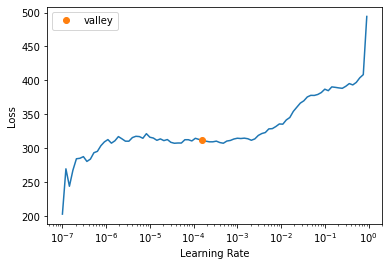

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(2, 6e-4)

epoch,train_loss,valid_loss,time
0,350.436584,350.528778,02:51
1,281.622925,343.456970,02:49


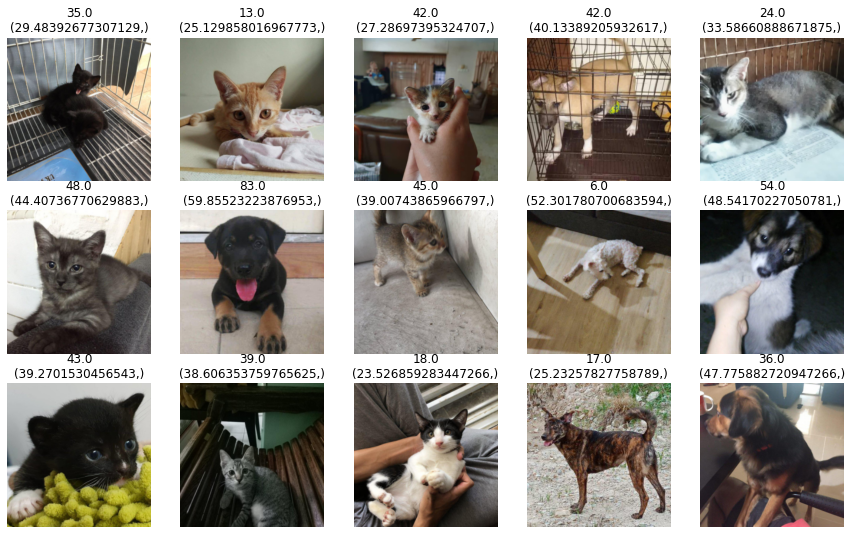

In [24]:
learn.show_results(max_n=15, dl=dls.valid)